Install `blackjax` if not already available. Note that `blackjax` is not available by default in Google Colab where this notebook was tested, therefore this step is necessary. Otherwise, it may be commented out.

In [1]:
!pip install blackjax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.1/300.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.3/170.3 kB 9.9 MB/s eta 0:00:00


Import all the required libraries at once.

In [2]:
import numpy as np
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
import time as t
from datetime import date
import jax
import jax.numpy as jnp
import blackjax

**Question:** _Suppose we are given a fixed number of balls/spheres, all of equal radius, contained in an open boundary condition box with hard walls. Further suppose that there exist a central (with respect to the box) attractive potential and spring like repulsion between the soft spheres. Then, we ask the question, "how do the correlations in the spacing between the spheres change as a function of the inverse temperature?"_

This is a soft-sphere problem, which is different from its conventional notion in the literature. The problem has numerous parameters,
- number of balls (spheres)
- spatial dimension of the space
- radius of the balls
- length of one side of the hypercubic container
- strength of the repulsive interactions between balls, given by `alpha`
- inverse temperature, given by `beta`

The following class encapsulates the required parameters for the soft-sphere problem. Along with the parameters we define a matrix that we call `A` that will be used to compute distances between all the different pairs of balls in a `jax` compatible way. The class also contains the option to define the central (w.r.t. the bounding box) potential to be repulsive, although we do not dwell on that option (but the user is encouraged to run that option as well). The class comes with a method to return the inverse temperature times the energy of a soft-sphere proposal configuration. This method will be inputted in the sampling algorithms. The returned value (inverse temperature times the energy of a soft-sphere proposal configuration) is the likelihood of the proposed configuration at the value of the inverse temperature.

In [3]:
class SoftSpherePacking:
  def __init__(self, number_balls, dimensions, radius, bounding_box_size=1., alpha=0.4, beta=1., attractive=True):
    self.number_balls = number_balls
    self.dimensions = dimensions
    self.radius = radius
    self.bounding_box_size = bounding_box_size
    self.alpha = alpha
    self.beta = beta
    self.attractive = attractive
    self.A = np.zeros([int(self.number_balls * (self.number_balls - 1) / 2), self.number_balls])
    self.origin = np.zeros((self.number_balls, self.dimensions)) + self.bounding_box_size / 2

    row = 0
    for i in range(self.number_balls - 1, 0, -1):
        self.A[row : row + i, self.number_balls - 1 - i] = np.ones(i)
        self.A[row : row + i, self.number_balls - i : self.number_balls] = -np.eye(i)
        row += i

  def cost(self, data):
    bounded_data = jnp.mod(data.copy(), self.bounding_box_size)
    if self.attractive:
      cost_overlap = -(self.beta * jnp.sum(jnp.sqrt(jnp.sum((bounded_data - self.origin) ** 2, axis=1))) / self.number_balls) + self.alpha * (self.beta * jnp.sum(jnp.sqrt(jnp.sum((bounded_data[1:] - bounded_data[:-1]) ** 2, axis=1))) / self.number_balls)
    else:
      cost_overlap = self.beta * jnp.sum(jnp.sqrt(jnp.sum((bounded_data - self.origin) ** 2, axis=1))) / self.number_balls
    return cost_overlap

Following is the Hamiltonian Monte Carlo sampling algorithm from `blackjax`. Although functions are provided in that package, we put it together in one coherent class whose interface is easy to use. User may simply provide an instance of the problem class (in our case, an instance of `SoftSpherePacking`) and an initial "position" (configuration) from the correct configuration space. Other options that a user may set are the options to "warmup" the sample and if so then the number of steps (time) for which to "warmup". `warmup=True` allows the sampler to choose parameters---maximum `step_size` to move in the configuration space, and the inertia of the points to resist change, given by the `inverse_mass_matrix`---automatically. Otherwise the user needs to specify these parameters later when calling the `run` method of this class to generate samples.

In [4]:
# global constants for sampling algorithm
DEFAULT_WARMUP_TIME = 1000
DEFAULT_STEP_SIZE = 0.01

class NutsWindowAdapt:
  def __init__(self, problem_instance, initial_position, warmup=True, warmup_time=DEFAULT_WARMUP_TIME):
    self.call_cost_function = lambda x : problem_instance.cost(**x)
    self.initial_position = initial_position
    self.warmup = warmup
    self.rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))

    if warmup:
      warmup_sampler = blackjax.window_adaptation(blackjax.nuts, self.call_cost_function)
      _, warmup_key, self.sample_key = jax.random.split(self.rng_key, 3)
      (self.state, self.parameters), _ = warmup_sampler.run(warmup_key, self.initial_position, num_steps=warmup_time)

  def inference_loop(self, rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)
    return states

  def run(self, run_time, inverse_mass_matrix, step_size=DEFAULT_STEP_SIZE):
    if self.warmup:
      kernel = blackjax.nuts(self.call_cost_function, **self.parameters).step
      states = self.inference_loop(self.sample_key, kernel, self.state, run_time)
    else:
      nuts_sampler = blackjax.nuts(self.call_cost_function, step_size, inverse_mass_matrix)
      initial_state = nuts_sampler.init(self.initial_position)
      _, sample_key = jax.random.split(self.rng_key)
      states = self.inference_loop(sample_key, nuts_sampler.step, initial_state, run_time)
    return states

Our choices of parameters, initial configuration, number of steps (time) for that the sampler to operate starting from the initial configuration with a prescribed maximum step size and the inverse mass matrix.

In [5]:
# constants for soft spheres
number_balls = 25
dimensions = 2
radius = 0.1
bounding_box_size = radius * 10.
run_time = 500

if dimensions == 2:
  # alternate, not random initial condition in 2 dimensions
  theta = np.linspace(0, 2 * np.pi, number_balls + 1)[:-1]
  initial_data = np.zeros((number_balls, dimensions))
  initial_data[:, 0] = bounding_box_size * np.cos(theta) / 3 + bounding_box_size / 2
  initial_data[:, 1] = bounding_box_size * np.sin(theta) / 3 + bounding_box_size / 2
else:
  initial_data = bounding_box_size * np.random.rand(number_balls, dimensions)

initial_position = {"data": initial_data}

step_size = 0.033
inverse_mass_matrix = np.ones(len(initial_position.keys()))

After numerous computational experiments, we chose to set the value of the `alpha` parameter to be 0.44.

In the following piece of code, we attempt to reveal the phase transition as a function of the inverse temperature `beta` in the $g_2$ correlation function of the spatial distances of the spheres. We iterate over numerous values of `beta` and for each value we we compute the pair wise distances between all the spheres for all steps of the sampling algorithm (equal to `run_time`). From these pair wise distances we compute the $g_2$ correlation function by histogramming the data into `bins` and normalizing by the "volume" of each bin (which depends on the number of spatial dimensions and the bin size).

`g2_data` stores the $g_2$ correlation function (over the range of the `bins`) for each `beta`


In [6]:
# for g2 calculations
bins = np.linspace(0, np.sqrt(dimensions), 150)

# empirical critical alpha
alpha = 0.44

# correlation function data
g2_data = list()

for beta in np.concatenate([2 ** np.linspace(-1, 7, 9), np.linspace(256, 512, 9)]):
  start_time = t.time()
  ssp = SoftSpherePacking(number_balls, dimensions, radius, alpha=alpha, beta=beta)
  nwa = NutsWindowAdapt(ssp, initial_position, warmup=False)
  history = nwa.run(run_time=run_time, inverse_mass_matrix=inverse_mass_matrix, step_size=step_size)
  history.position["data"] = np.mod(history.position["data"], 1)
  history = history.position['data']

  plot_data = pdist(np.reshape(history[:], [-1, 2]))
  histogram_data, bins = np.histogram(plot_data.copy(), bins=bins)
  g2_data.append(histogram_data.copy() / (len(plot_data) * (bins[1:]**dimensions - bins[:-1]**dimensions)))
  print("\r alpha: " + format(np.round(alpha, 2), '.2f') + ", beta: " + format(np.round(beta, 2), '.2f') + ", time elapsed: " + format(np.round(t.time() - start_time, 4), '.4f') + "s", end='')

 alpha: 0.44, beta: 512.00, time elapsed: 9.9116s

On the plot on the left, we depict the $g_2$ correlation function for different values of `beta`, and, on the plot of the right, we depict the gradient for each $g_2$ correlation function line plot of the left hand side plot.

**Left:** At high temperatures or low inverse temperatures (blue), the correlation function is almost a straight line with a negative slope. At low temperatures or high inverse temperatures (red), the correlation function skews towards 0 displacement between the balls/spheres.

**Right:** For high temperatures or low inverse temperatures (blue), the gradient of $g_2$ is a linearly increasing function till ball displacement of about 1 after which it rapidly saturates to 0. At low temperature or high inverse temperature (red), the gradient has more features for low ball displacement and rapidly saturates to 0 after ball displacement of 0.5.

The change in the behaviour of the correlation functions and their gradients with increasing `beta` are signatures of a phase transition.

Note the behaviour may differ for different strength of repulsive interation parameter `alpha` and also for repulsive central potential.

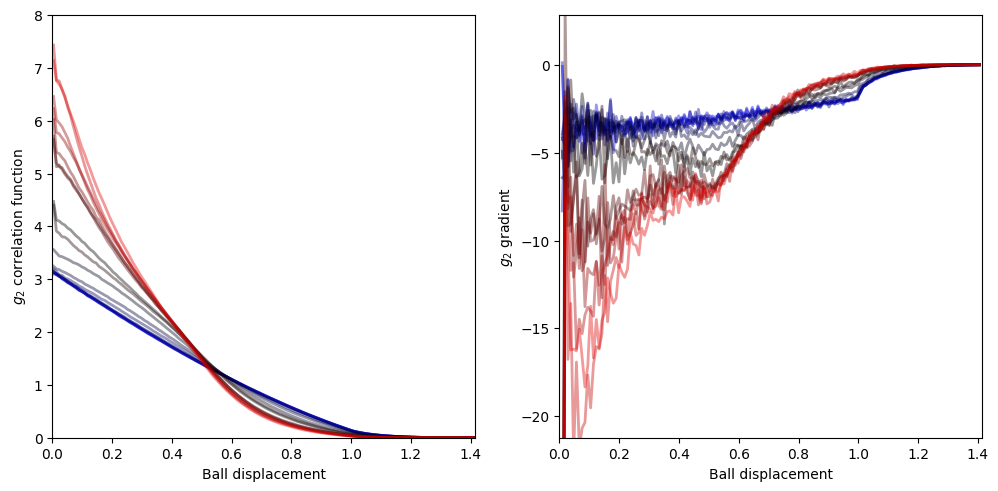

In [7]:
# plotting constants
opacity=0.4
linewidth=2

# plotting data
xaxis = (bins[1:] + bins[:-1])/2
gradient_xaxis = (xaxis[1:] + xaxis[:-1])/2
g2_data = np.array(g2_data)

# plot
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))

for i in range(len(g2_data)):
  if i < 9:
    color = [0, 0, 1 - i / 9]
    ax[0].plot(xaxis[:], g2_data[i], alpha=opacity, color=color, linewidth=linewidth)
    gradient_g2_data = (g2_data[i,1:] - g2_data[i,:-1]) / (bins[2] - bins[1])
    ax[1].plot(gradient_xaxis, gradient_g2_data, alpha=opacity, color=color, linewidth=linewidth)
  else:
    color = [(i - 9) / (len(g2_data) - 9), 0, 0]
    ax[0].plot(xaxis[:], g2_data[i], alpha=opacity, color=color, linewidth=linewidth)
    gradient_g2_data = (g2_data[i,1:] - g2_data[i,:-1]) / (bins[2] - bins[1])
    ax[1].plot(gradient_xaxis, gradient_g2_data, alpha=opacity, color=color, linewidth=linewidth)

# plot formatting
ax[0].set_xlim([0, np.sqrt(2)])
ax[0].set_xlabel("Ball displacement")
ax[0].set_ylim([0, 8])
ax[0].set_ylabel(r"$g_2$ correlation function")
ax[0].set_aspect(np.sqrt(2)/8)

ax[1].set_xlim([0, np.sqrt(2)])
ax[1].set_xlabel("Ball displacement")
ax[1].set_ylim([-15 * np.sqrt(2), 2 * np.sqrt(2)])
ax[1].set_ylabel(r"$g_2$ gradient")
ax[1].set_aspect(1/17)

Following plots only correspond to the final inverse temperature that was tested above.

The plot on the left compares the initial configuration of the soft spheres with the final configuration sample generated by the sampler. The plot on the right depicts an energy profile as a function of the steps (total of `run_time`), where each successive point on the graph is the negative inverse temperature times the energy (also known as the log likelihood) of a configuration sample generated by the sampler.

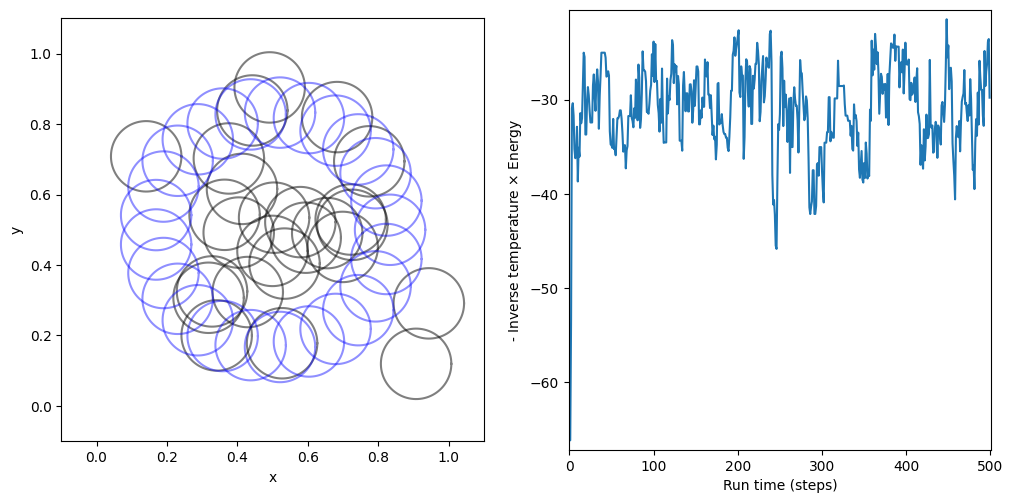

In [8]:
# plots for last alpha and beta tested above
def plot_circles(ax, centers, radii, color='black', alpha=0.5):
    theta = np.linspace(0, 2 * np.pi, 100)
    for i in range(len(centers)):
        ax.plot(radii[i] * np.cos(theta) + centers[i, 0], radii[i] * np.sin(theta) + centers[i, 1], color=color, alpha=alpha)


# plotting data
frame_from_last = 1
radii = radius * np.ones(len(history[-frame_from_last]))
centers_final = history[-frame_from_last]
centers_initial = initial_data
delta_y = 2.
log_likelihood_list = list()
for i in range(history.shape[0]):
  log_likelihood_list.append(ssp.cost(history[i]))
log_likelihood_list = np.array(log_likelihood_list)

# plot
fig, ax = plt.subplots(ncols=2, width_ratios=[1, 1], figsize=(12, 6))

plot_circles(ax[0], centers_final, radii)
plot_circles(ax[0], centers_initial, radii, 'blue', alpha=alpha)

ax[1].plot(log_likelihood_list)

# plot formatting
ax[0].set_xlim([0 - radius, bounding_box_size + radius])
ax[0].set_xlabel("x")
ax[0].set_ylim([0 - radius, bounding_box_size + radius])
ax[0].set_ylabel("y")
ax[0].set_aspect("equal")

ax[1].set_xlim([-1, run_time+1])
ax[1].set_xlabel("Run time (steps)")
ax[1].set_ylim([np.min(log_likelihood_list) - delta_y / 2, np.max(log_likelihood_list) + delta_y / 2])
ax[1].set_ylabel(r"- Inverse temperature $\times$ Energy")
ax[1].set_aspect(np.abs(run_time / (np.max(log_likelihood_list) - np.min(log_likelihood_list))))